In [1]:
import pandas as pf
import os

In [2]:
path = "/kaggle/input/sat-data/data"

In [3]:
images_dir = os.path.join(path, "images")
labels_dir = os.path.join(path, "labels")

In [4]:
print(f"Base data: {path}")
print(f"Images: {images_dir}")
print(f"Labels: {labels_dir}")

Base data: /kaggle/input/sat-data/data
Images: /kaggle/input/sat-data/data/images
Labels: /kaggle/input/sat-data/data/labels


In [5]:
len(os.listdir(labels_dir))

456

In [6]:
len(os.listdir(images_dir))

306

# **Visualization**

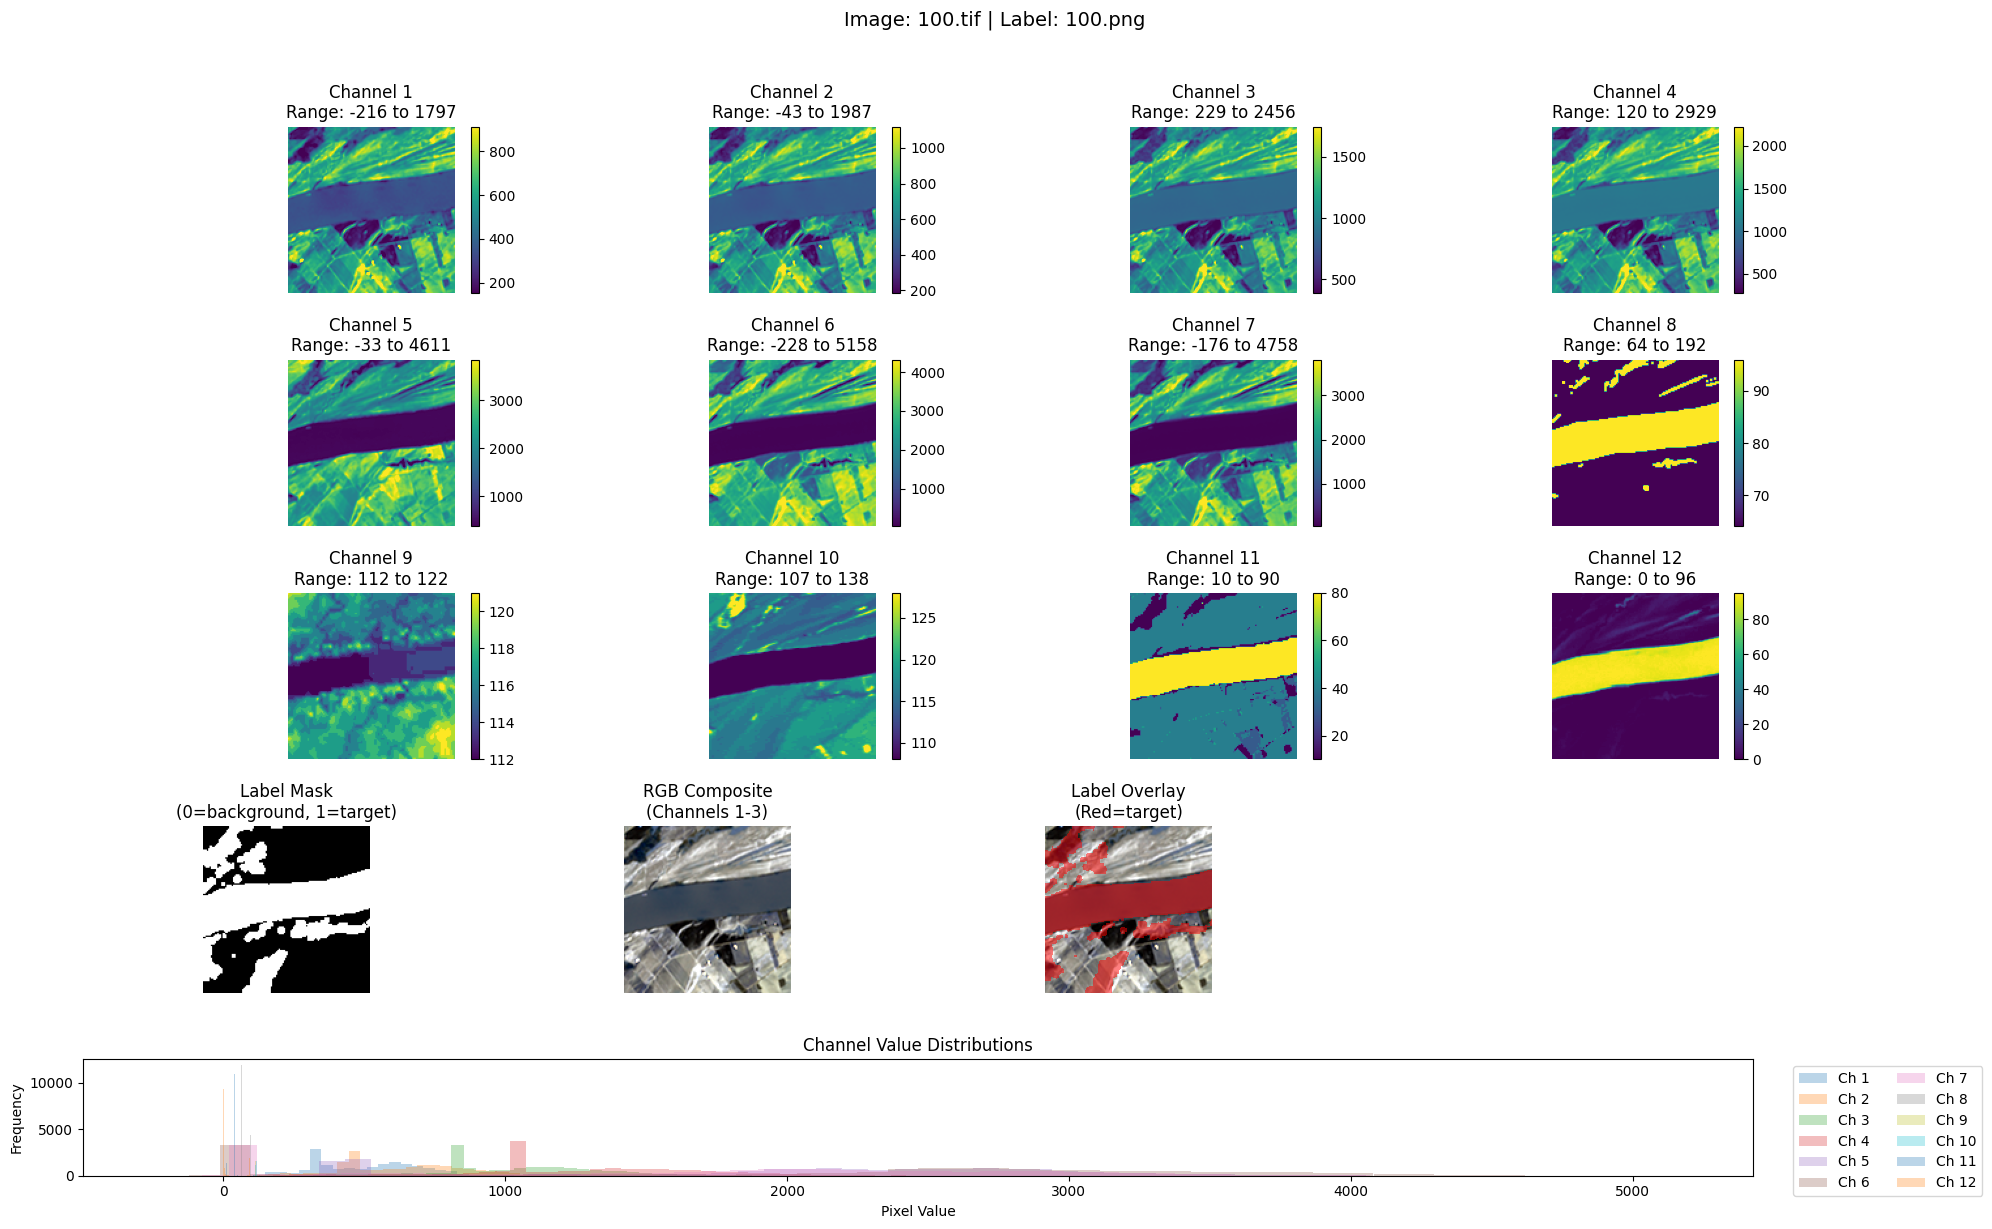

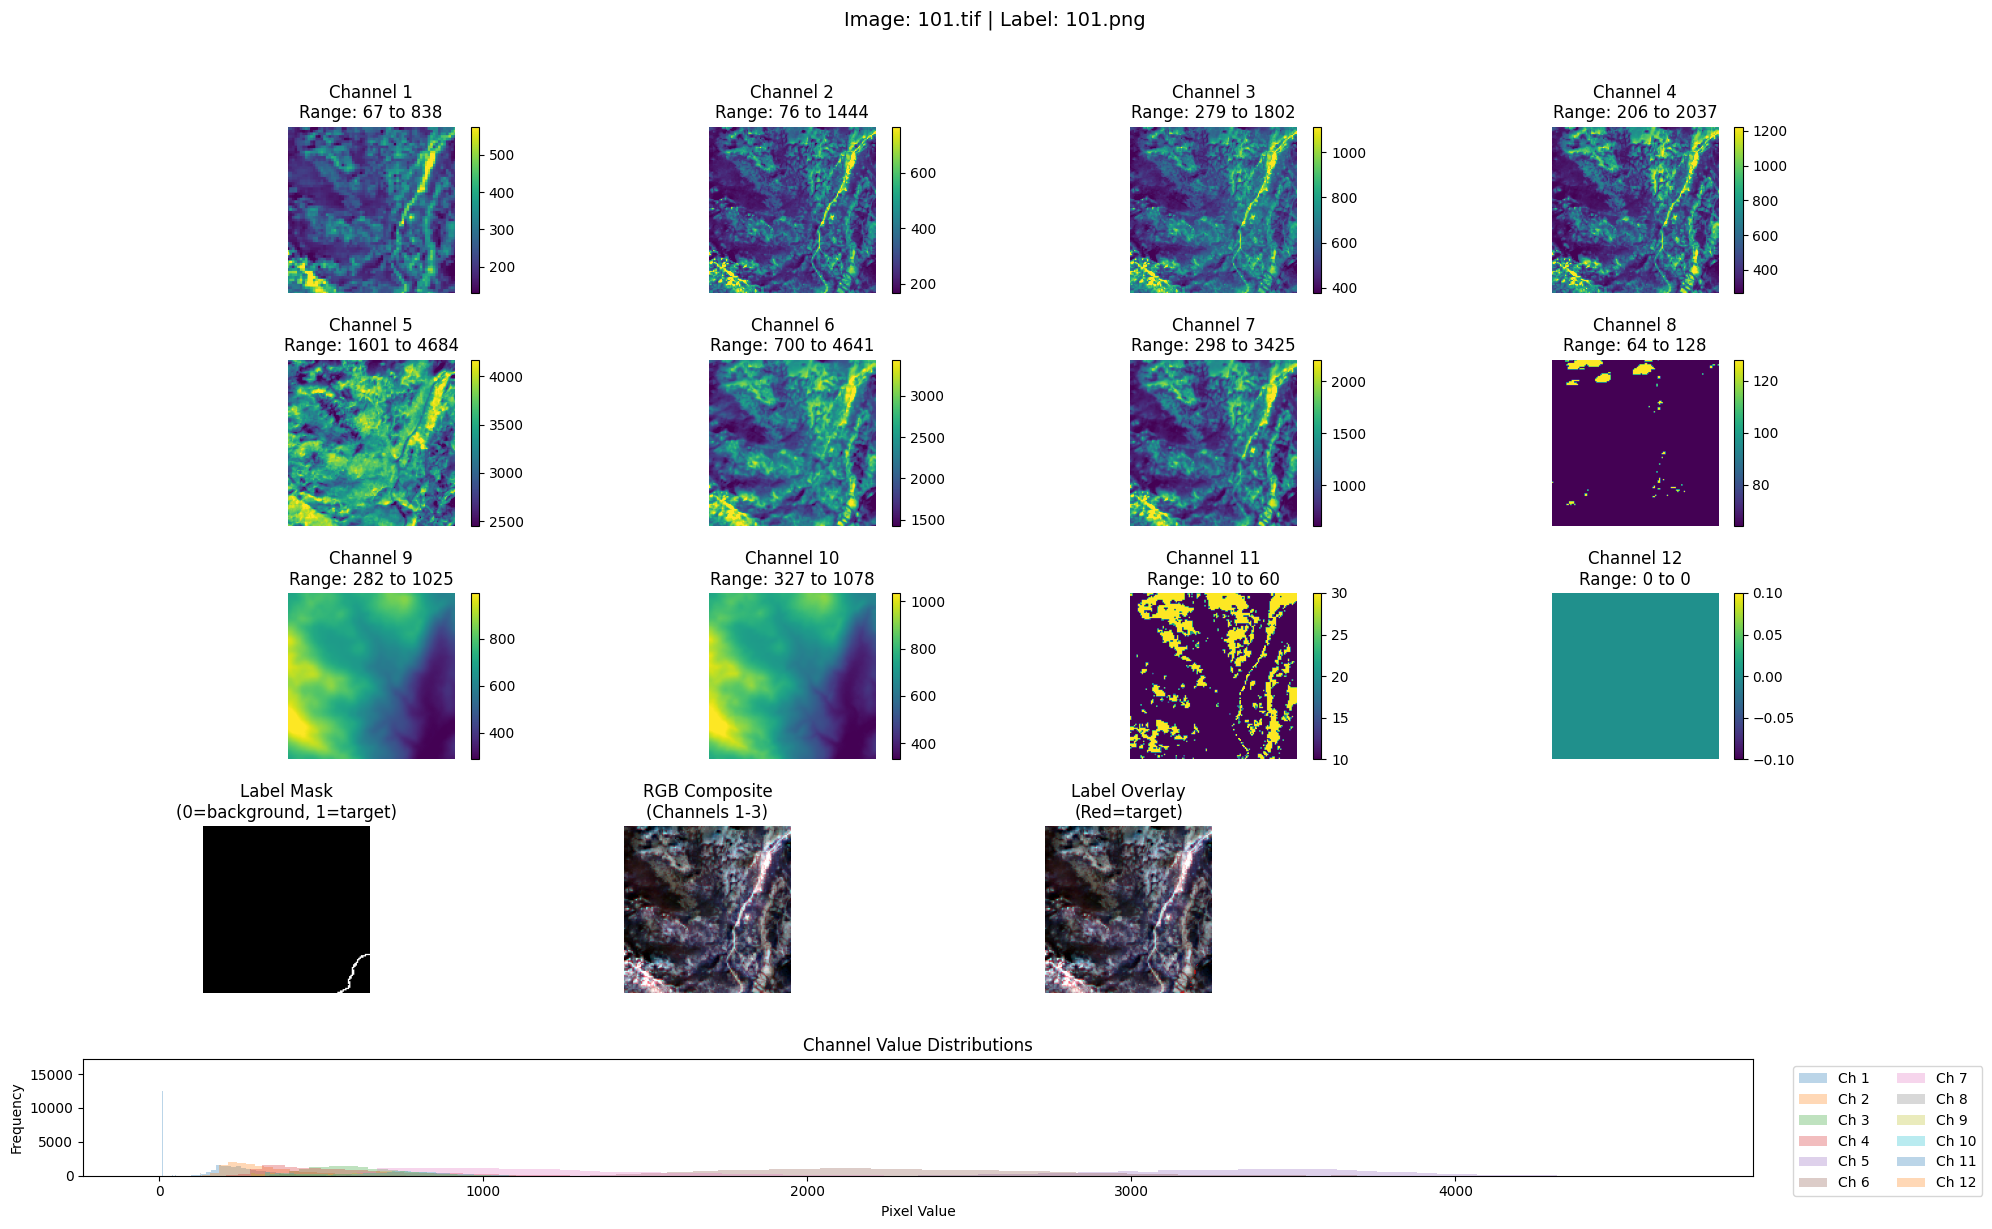

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from PIL import Image

def visualize_12channel_samples(image_dir, label_dir, num_samples=5):
    # Get lists of files
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

    # Create matching pairs
    matched_pairs = []
    for img_file in image_files[:num_samples]:
        img_base = os.path.splitext(img_file)[0]
        # Find matching label (either exact or with suffix)
        label_match = next((f for f in label_files if f.startswith(img_base)), None)
        if label_match:
            matched_pairs.append((img_file, label_match))

    if not matched_pairs:
        print("No valid pairs found!")
        return

    for img_file, label_file in matched_pairs:
        try:
            # Load the 12-channel image
            img_path = os.path.join(image_dir, img_file)
            img = tifffile.imread(img_path)  # Shape: (128, 128, 12)

            # Load the label
            label_path = os.path.join(label_dir, label_file)
            label = np.array(Image.open(label_path))  # Shape: (128, 128)

            # Create figure with adjusted layout
            fig = plt.figure(figsize=(20, 12))
            fig.suptitle(f"Image: {img_file} | Label: {label_file}", fontsize=14, y=1.02)

            # Grid layout: 3 rows, 4 columns
            gs = fig.add_gridspec(5, 4, height_ratios=[1, 1, 1, 1, 0.7])

            # Plot first 4 channels (top row)
            for i in range(4):
                ax = fig.add_subplot(gs[0, i])
                channel = img[:, :, i]
                im = ax.imshow(channel, cmap='viridis',
                             vmin=np.percentile(channel, 1),
                             vmax=np.percentile(channel, 99))
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(f'Channel {i+1}\nRange: {channel.min()} to {channel.max()}')
                ax.axis('off')
            for i in range(4):
                ax = fig.add_subplot(gs[1, i])
                channel = img[:, :, i+4]
                im = ax.imshow(channel, cmap='viridis',
                             vmin=np.percentile(channel, 1),
                             vmax=np.percentile(channel, 99))
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(f'Channel {i+5}\nRange: {channel.min()} to {channel.max()}')
                ax.axis('off')
            for i in range(4):
                ax = fig.add_subplot(gs[2, i])
                channel = img[:, :, i+8]
                im = ax.imshow(channel, cmap='viridis',
                             vmin=np.percentile(channel, 1),
                             vmax=np.percentile(channel, 99))
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                ax.set_title(f'Channel {i+9}\nRange: {channel.min()} to {channel.max()}')
                ax.axis('off')
            # Plot label (middle left)
            ax1 = fig.add_subplot(gs[3, 0])
            ax1.imshow(label, cmap='gray')
            ax1.set_title('Label Mask\n(0=background, 1=target)')
            ax1.axis('off')

            # Plot RGB composite (middle center)
            ax2 = fig.add_subplot(gs[3, 1])
            if img.shape[2] >= 3:
                rgb = np.stack([
                    (img[:,:,0] - np.percentile(img[:,:,0], 1)) /
                    (np.percentile(img[:,:,0], 99) - np.percentile(img[:,:,0], 1)),
                    (img[:,:,1] - np.percentile(img[:,:,1], 1)) /
                    (np.percentile(img[:,:,1], 99) - np.percentile(img[:,:,1], 1)),
                    (img[:,:,2] - np.percentile(img[:,:,2], 1)) /
                    (np.percentile(img[:,:,2], 99) - np.percentile(img[:,:,2], 1))
                ], axis=-1)
                rgb = np.clip(rgb, 0, 1)
                ax2.imshow(rgb)
                ax2.set_title('RGB Composite\n(Channels 1-3)')
                ax2.axis('off')

            # Plot label overlay (middle right)
            ax3 = fig.add_subplot(gs[3, 2])
            if img.shape[2] >= 3:
                ax3.imshow(rgb)
            else:
                ax3.imshow(img[:,:,0], cmap='gray')
            ax3.imshow(np.ma.masked_where(label == 0, label),
                      cmap='autumn', alpha=0.5)
            ax3.set_title('Label Overlay\n(Red=target)')
            ax3.axis('off')

            # Plot histogram (bottom row - spans all columns)
            ax4 = fig.add_subplot(gs[4, :])
            for i in range(img.shape[2]):
                ax4.hist(img[:,:,i].ravel(), bins=50, alpha=0.3, label=f'Ch {i+1}')
            ax4.set_title('Channel Value Distributions')
            ax4.set_xlabel('Pixel Value')
            ax4.set_ylabel('Frequency')
            ax4.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=2)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue

# Run the visualization
visualize_12channel_samples(images_dir, labels_dir)

# **Batch Processing for Training**

In [10]:
import os
import numpy as np
import tifffile
from PIL import Image
from sklearn.preprocessing import StandardScaler
from skimage import exposure
import matplotlib.pyplot as plt

class WaterBodyPreprocessor:
    def __init__(self):
        self.band_info = {
            0: {'name': 'Coastal aerosol', 'type': 'optical'},
            1: {'name': 'Blue', 'type': 'optical'},
            2: {'name': 'Green', 'type': 'optical'},
            3: {'name': 'Red', 'type': 'optical'},
            4: {'name': 'NIR', 'type': 'optical'},
            5: {'name': 'SWIR1', 'type': 'optical'},
            6: {'name': 'SWIR2', 'type': 'optical'},
            7: {'name': 'QA Band', 'type': 'quality'},
            8: {'name': 'MeritDEM', 'type': 'elevation'},
            9: {'name': 'CopernicusDEM', 'type': 'elevation'},
            10: {'name': 'ESA world cover map', 'type': 'landcover'},
            11: {'name': 'Water occurrence probability', 'type': 'derived'}
        }
        self.water_bands = [2, 4, 5, 11]  # Green, NIR, SWIR1, Water probability
        self.optical_bands = [0, 1, 2, 3, 4, 5, 6]  # All optical bands

    def load_and_preprocess(self, img_path):
        """Load and preprocess 12-channel TIFF image"""
        img = tifffile.imread(img_path)
        processed = np.zeros((img.shape[0], img.shape[1], 0), dtype=np.float32)

        # Process optical bands (0-6)
        optical_data = img[:, :, self.optical_bands]
        for i in range(optical_data.shape[2]):
            band = optical_data[:, :, i]
            p1, p99 = np.percentile(band, [1, 99])
            norm_band = (band - p1) / (p99 - p1 + 1e-8)
            processed = np.dstack((processed, np.clip(norm_band, 0, 1)))

        # Process elevation bands (8-9)
        elevation_data = img[:, :, [8, 9]]
        if elevation_data.size > 0:
            scaler = StandardScaler()
            elev_norm = scaler.fit_transform(
                elevation_data.reshape(-1, 2)).reshape(*elevation_data.shape)
            processed = np.dstack((processed, elev_norm))

        # Process water probability band (11)
        water_prob = img[:, :, 11:12]
        water_prob_norm = 1 / (1 + np.exp(-water_prob/100))
        processed = np.dstack((processed, water_prob_norm))

        # Calculate water indices
        green = processed[:, :, 2]
        nir = processed[:, :, 4]
        swir1 = processed[:, :, 5]

        ndwi = (green - nir) / (green + nir + 1e-8)
        mndwi = (green - swir1) / (green + swir1 + 1e-8)

        return np.dstack((processed, ndwi, mndwi))

    def preprocess_label(self, label_path):
        label = np.array(Image.open(label_path))
        return label.astype(np.float32)

    def batch_preprocess(self, images_dir, labels_dir, output_dir=None):
        """Process all images in directory with proper path handling"""
        # Verify directories exist
        if not os.path.exists(images_dir):
            raise FileNotFoundError(f"Images directory not found: {images_dir}")
        if not os.path.exists(labels_dir):
            raise FileNotFoundError(f"Labels directory not found: {labels_dir}")

        image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]
        X_processed, y_processed = [], []

        for img_file in image_files:
            base_name = os.path.splitext(img_file)[0]

            # Handle both 1.png and 1_353.png cases
            possible_labels = [f for f in os.listdir(labels_dir)
                             if f.startswith(base_name) and f.endswith('.png')]

            if not possible_labels:
                print(f"No matching label found for {img_file}")
                continue

            label_file = possible_labels[0]  # Take the first match

            try:
                img_path = os.path.join(images_dir, img_file)
                label_path = os.path.join(labels_dir, label_file)

                img = self.load_and_preprocess(img_path)
                label = self.preprocess_label(label_path)

                X_processed.append(img)
                y_processed.append(label)

                if output_dir:
                    os.makedirs(output_dir, exist_ok=True)
                    np.save(os.path.join(output_dir, f"{base_name}_img.npy"), img)
                    np.save(os.path.join(output_dir, f"{base_name}_label.npy"), label)

            except Exception as e:
                print(f"Error processing {img_file}: {str(e)}")
                continue

        return np.array(X_processed), np.array(y_processed)
preprocessor = WaterBodyPreprocessor()


# Process all images
X_processed, y_processed = preprocessor.batch_preprocess(
    images_dir,
    labels_dir,
    #output_dir=output_dir
)

print(f"Processed images shape: {X_processed.shape}")  # (n_samples, 128, 128, 13)
print(f"Processed labels shape: {y_processed.shape}")  # (n_samples, 128, 128)

Processed images shape: (306, 128, 128, 12)
Processed labels shape: (306, 128, 128)


# **Visualize Processed Samples**

In [11]:
def visualize_water_features(sample_img, sample_label):
    """Visualize features relevant for water detection"""
    plt.figure(figsize=(18, 10))

    # Assuming channels are: [B, G, R, NIR, SWIR1, SWIR2, ...]
    water_sensitive_bands = {
        1: 'Green (Best for water)',
        3: 'NIR (Water absorbs)',
        4: 'SWIR1 (Good water contrast)',
        -1: 'NDWI (Water Index)'
    }

    # Plot important bands
    for i, (band_idx, title) in enumerate(water_sensitive_bands.items()):
        ax = plt.subplot(2, 4, i+1)
        band = sample_img[:, :, band_idx]
        im = ax.imshow(band, cmap='Blues' if 'NDWI' in title else 'viridis')
        plt.colorbar(im, ax=ax)
        ax.set_title(f'{title}\nRange: {band.min():.2f}-{band.max():.2f}')
        ax.axis('off')

    # Plot label and composites
    ax = plt.subplot(2, 4, 5)
    ax.imshow(sample_label, cmap='gray')
    ax.set_title('Ground Truth Water Mask')
    ax.axis('off')

    # False Color Composite (SWIR1, NIR, Red)
    if sample_img.shape[2] >= 5:
        ax = plt.subplot(2, 4, 6)
        fcc = np.stack([sample_img[:, :, 4],  # SWIR1
                        sample_img[:, :, 3],  # NIR
                        sample_img[:, :, 2]], axis=-1)  # Red
        fcc = exposure.rescale_intensity(fcc)
        ax.imshow(fcc)
        ax.set_title('False Color (SWIR1,NIR,R)\nWater=Dark')
        ax.axis('off')

    # NDWI with threshold
    ax = plt.subplot(2, 4, 7)
    ndwi = sample_img[:, :, -1]  # Our added NDWI channel
    ax.imshow(ndwi > 0.2, cmap='coolwarm')  # Typical water threshold
    ax.set_title('NDWI > 0.2 (Water Candidate)')
    ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the first sample
visualize_water_features(X_processed[0], y_processed[0])

# **U-Net Model Architecture** | Train Without DA

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split

def improved_unet(input_shape=(128, 128, 13)):
    """U-Net architecture with proper dimension handling"""
    inputs = layers.Input(shape=input_shape, name='input_layer')

    # Downsample path
    # Block 1
    conv1 = layers.Conv2D(64, 3, padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, 3, padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    conv2 = layers.Conv2D(128, 3, padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, 3, padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, 3, padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)

    # Upsample path
    # Block 4
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(128, 3, padding='same')(up4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(128, 3, padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)

    # Block 5
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(64, 3, padding='same')(up5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(64, 3, padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)

    # Output layer - ensure output has 1 channel
    outputs = layers.Conv2D(1, 1, activation='sigmoid', name='output_layer')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def fixed_iou_coef(y_true, y_pred, smooth=1):
    """Fixed IoU metric with proper dimension handling"""
    y_true = K.expand_dims(y_true, -1)  # Add channel dimension if missing
    y_pred = K.expand_dims(y_pred, -1)  # Add channel dimension if missing

    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='binary_crossentropy',
                 metrics=['accuracy', fixed_iou_coef])
    return model

def train_water_segmentation_model_withoutAut(X, y, validation_split=0.2, batch_size=16, epochs=100):
    if y.ndim == 3:
        y = np.expand_dims(y, -1)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=validation_split, random_state=42
    )

    print(f"Input shape: {X_train.shape}")
    print(f"Output shape: {y_train.shape}")

    # Create and compile model
    model = improved_unet(input_shape=X.shape[1:])
    model = compile_model(model)
    model.summary()

    # Callbacks
    callbacks = [
        ModelCheckpoint('best_water_model.h5',
                       monitor='val_iou_coef',
                       mode='max',
                       save_best_only=True,
                       verbose=1),
        EarlyStopping(monitor='val_iou_coef',
                     patience=15,
                     mode='max',
                     restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',
                          factor=0.2,
                          patience=5,
                          min_lr=1e-6,
                          verbose=1)
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history, X_val, y_val

2025-07-18 14:12:33.934685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752847954.115001      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752847954.173408      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
print("\nVerifying input shapes:")
print(f"X_train_aug shape: {X_processed.shape}")
print(f"y_train_aug shape: {y_processed.shape}")

# Train the model
print("\nStarting training...")
model, history, X_val, y_val = train_water_segmentation_model_withoutAut(X_processed, y_processed)


Verifying input shapes:
X_train_aug shape: (306, 128, 128, 12) (should be [n, 128, 128, 12])
y_train_aug shape: (306, 128, 128) (should be [n, 128, 128] or [n, 128, 128, 1])

Starting training...
Input shape: (244, 128, 128, 12)
Output shape: (244, 128, 128, 1)


I0000 00:00:1752847966.053379      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 1,893,441 (7.22 MB)

 Trainable params: 1,890,881 (7.21 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)
I0000 00:00:1752847977.655269      98 service.cc:148] XLA service 0x7ea5540abc70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752847977.656105      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752847978.623267      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3881 - fixed_iou_coef: 0.1627 - loss: 0.9039 

I0000 00:00:1752847989.700313      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5300 - fixed_iou_coef: 0.2252 - loss: 0.7683

E0000 00:00:1752847992.593691      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752847992.838014      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.5366 - fixed_iou_coef: 0.2265 - loss: 0.7648

E0000 00:00:1752848001.294680      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752848001.542747      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 865ms/step - accuracy: 0.5423 - fixed_iou_coef: 0.2278 - loss: 0.7617 - val_accuracy: 0.7564 - val_fixed_iou_coef: 0.2338 - val_loss: 0.6678 - learning_rate: 1.0000e-04
Epoch 2/100
 2/16 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7478 - fixed_iou_coef: 0.2602 - loss: 0.6429 

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_iou_coef available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_coef` which is not available. Available metrics are: accuracy,fixed_iou_coef,loss,val_accuracy,val_fixed_iou_coef,val_loss
  current = self.get_monitor_value(logs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7654 - fixed_iou_coef: 0.2533 - loss: 0.5970 - val_accuracy: 0.7757 - val_fixed_iou_coef: 0.2295 - val_loss: 0.6494 - learning_rate: 1.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7745 - fixed_iou_coef: 0.2258 - loss: 0.5577 - val_accuracy: 0.7686 - val_fixed_iou_coef: 0.2266 - val_loss: 0.6271 - learning_rate: 1.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7931 - fixed_iou_coef: 0.2498 - loss: 0.5033 - val_accuracy: 0.7474 - val_fixed_iou_coef: 0.2178 - val_loss: 0.6160 - learning_rate: 1.0000e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8199 - fixed_iou_coef: 0.2289 - loss: 0.4645 - val_accuracy: 0.7441 - val_fixed_iou_coef: 0.2145 - val_loss: 0.5947 - learning_rate: 1.0000e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7891 - fixed_iou_coef: 0.2318 - loss: 0.4895 - val_accuracy: 0.7169 - val_fixed_iou_coef: 0.2060 - val_los

# **Evaluation Without DA**

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 128, 128, 12))
  warnings.warn(msg)


1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)
E0000 00:00:1752848140.174734      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752848140.428634      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


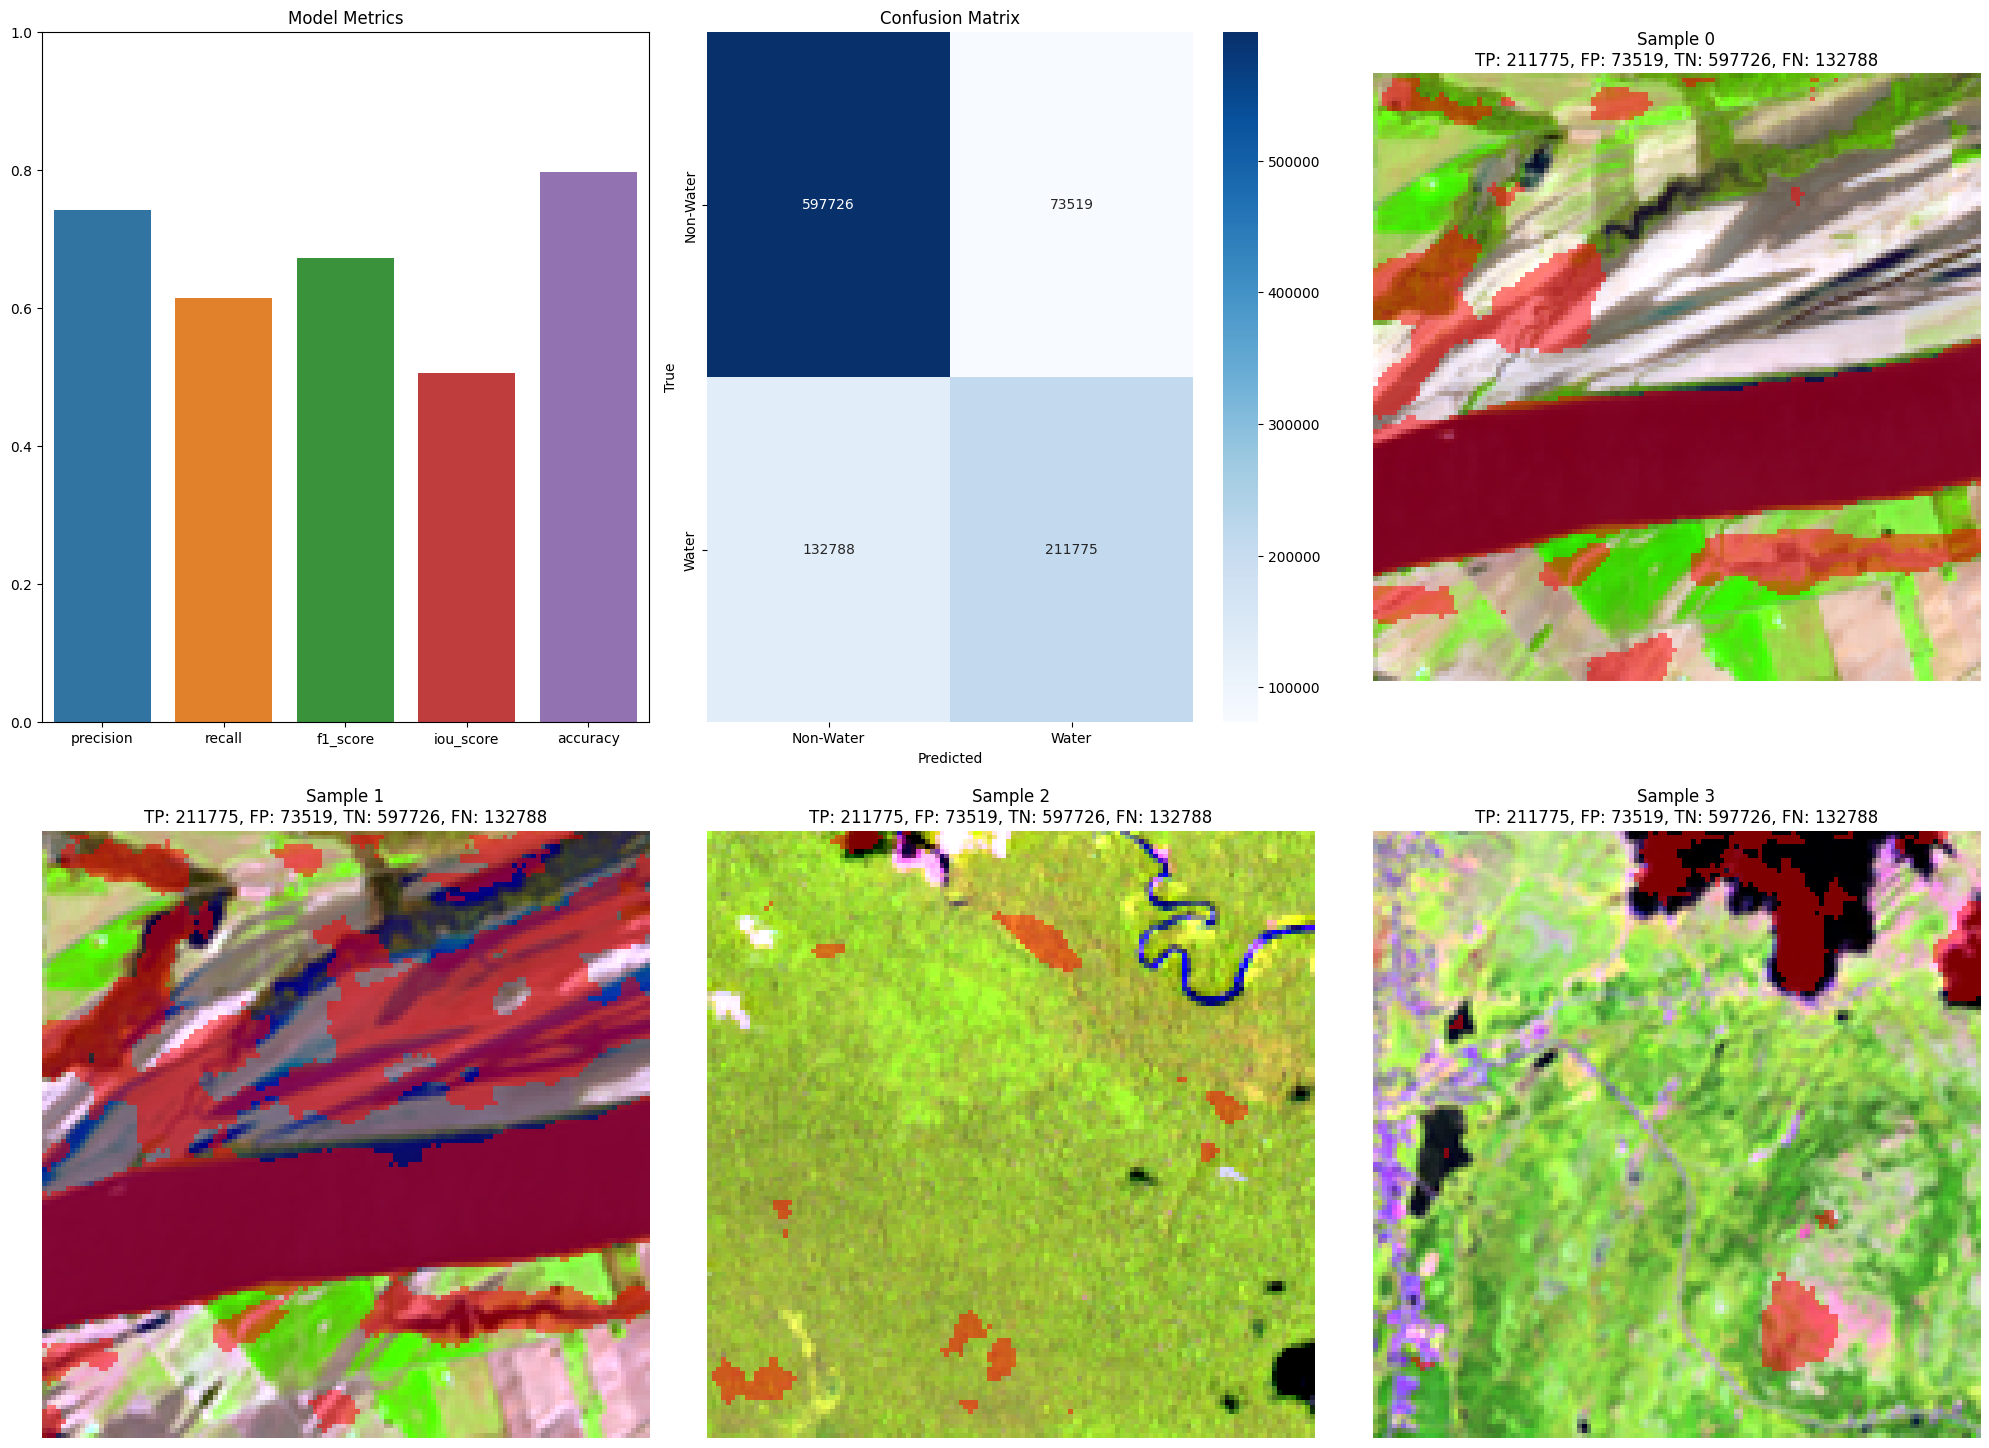

{'precision': 0.7423044298162598,
 'recall': 0.6146190972333071,
 'f1_score': 0.672454223736499,
 'iou_score': 0.5065393870102037,
 'accuracy': 0.7969035487021169}

In [14]:
from sklearn.metrics import (precision_score, recall_score, 
                            f1_score, jaccard_score, confusion_matrix)
import seaborn as sns
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_test, y_test, threshold=0.5):
    robust dimension handling
    
    # Ensure proper dimensions
    if y_test.ndim == 3:
        y_test = np.expand_dims(y_test, -1)  # Add channel dimension if missing
    elif y_test.ndim == 4 and y_test.shape[-1] == 1:
        y_test = y_test[..., 0]  # Remove extra channel if present
        y_test = np.expand_dims(y_test, -1)  # Then add back correctly

    # Predict probabilities
    y_pred_prob = model.predict(X_test)
    
    # Convert to binary predictions
    y_pred = (y_pred_prob > threshold).astype(np.float32)
    
    # Calculate metrics - ensure we use the correct dimensions
    y_test_flat = y_test[..., 0].flatten()  # Remove channel dim for metrics
    y_pred_flat = y_pred[..., 0].flatten()  # Remove channel dim for metrics
    
    metrics = {
        'precision': precision_score(y_test_flat, y_pred_flat),
        'recall': recall_score(y_test_flat, y_pred_flat),
        'f1_score': f1_score(y_test_flat, y_pred_flat),
        'iou_score': jaccard_score(y_test_flat, y_pred_flat),
        'accuracy': np.mean(y_test_flat == y_pred_flat)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test_flat, y_pred_flat)
    
    return metrics, cm, y_pred_prob

def plot_evaluation_results(metrics, cm, sample_idx, X_test, y_test, y_pred_prob):
    """
    Visualize evaluation metrics and sample predictions
    with proper dimension handling
    """
    plt.figure(figsize=(20, 15))
    
    # 1. Plot metrics
    plt.subplot(2, 3, 1)
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    plt.title('Model Metrics')
    plt.ylim(0, 1)
    
    # 2. Plot confusion matrix
    plt.subplot(2, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Water', 'Water'],
                yticklabels=['Non-Water', 'Water'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # 3-6. Plot sample predictions
    for i in range(4):
        idx = sample_idx[i] if isinstance(sample_idx, list) else sample_idx + i
        
        # Create subplot
        plt.subplot(2, 3, 3+i)
        
        # Display false color composite (SWIR1, NIR, Red)
        img = np.stack([X_test[idx,:,:,5],  # SWIR1
                        X_test[idx,:,:,4],  # NIR
                        X_test[idx,:,:,3]], axis=-1)  # Red
        img = exposure.rescale_intensity(img)
        
        # Handle different label dimensions
        if y_test.ndim == 4:
            true_mask = y_test[idx,:,:,0]
        else:
            true_mask = y_test[idx]
            
        # Handle different prediction dimensions
        if y_pred_prob.ndim == 4:
            pred_mask = y_pred_prob[idx,:,:,0] > 0.5
        else:
            pred_mask = y_pred_prob[idx] > 0.5
        
        # Display
        plt.imshow(img)
        plt.imshow(np.ma.masked_where(pred_mask == 0, pred_mask), 
                   cmap='autumn', alpha=0.5)
        plt.title(f'Sample {idx}\nTP: {cm[1,1]}, FP: {cm[0,1]}, TN: {cm[0,0]}, FN: {cm[1,0]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return metrics

# Proper usage example:
# Ensure validation data has correct shapes
if y_val.ndim == 3:
    y_val = np.expand_dims(y_val, -1)  # Add channel dimension if needed

# Then evaluate
metrics, cm, y_pred_prob = evaluate_model(model, X_val, y_val)
plot_evaluation_results(metrics, cm, 0, X_val, y_val, y_pred_prob)

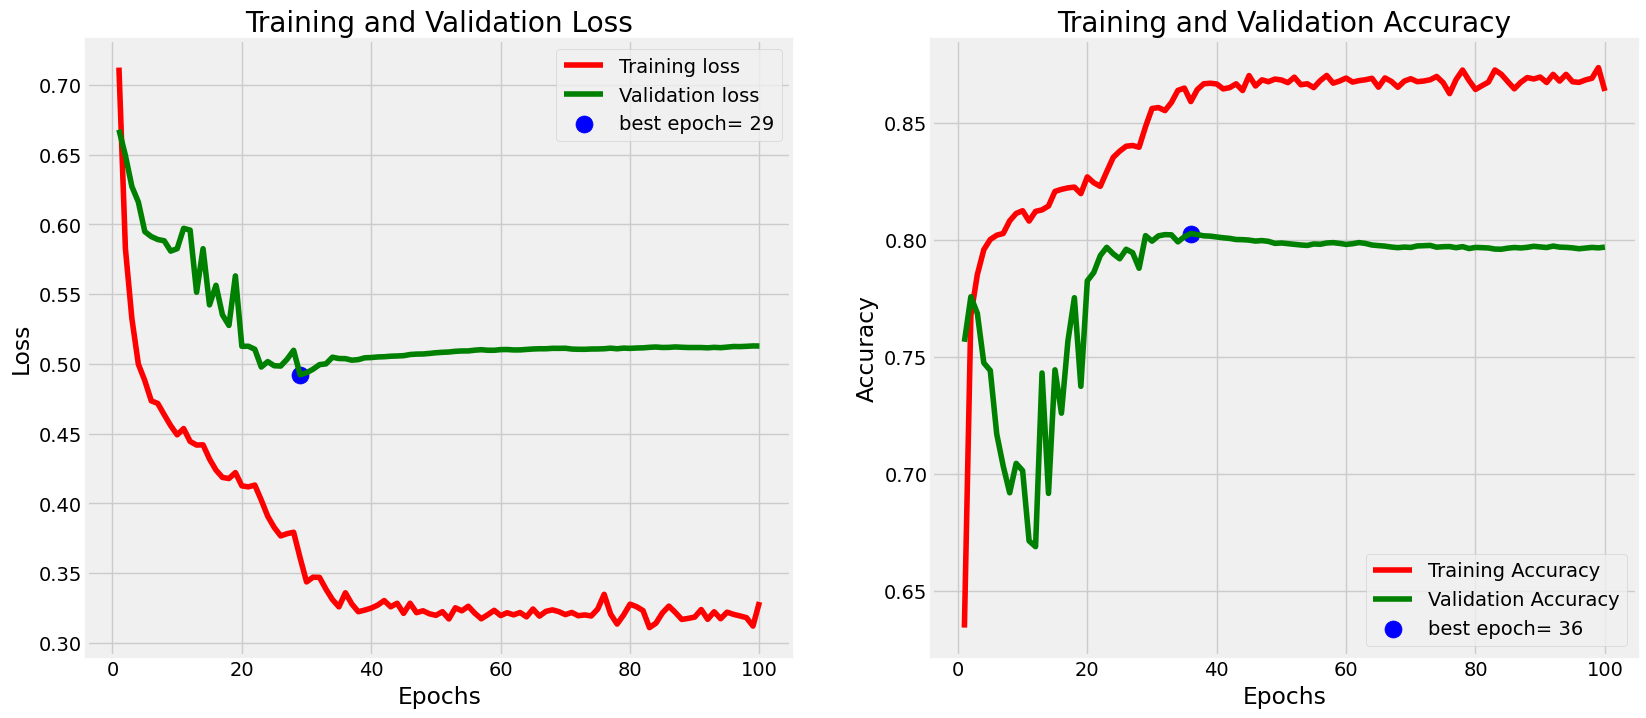

In [15]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()
plot_training(history)

------------------------

-------------

# **Data Augmentation**

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CorrectedMultispectralAugmenter:
    def __init__(self, original_num_channels=12):
        self.original_num_channels = original_num_channels
        
        # Optical bands augmentation (bands 0-6)
        self.optical_aug = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect'
        )
        
        # Special handling for non-optical bands
        self.geometric_aug = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            fill_mode='reflect'
        )

    def augment_sample(self, img, label):
        """Apply consistent augmentations while preserving channel structure"""
        # Get random transformation parameters
        transform_params = self.optical_aug.get_random_transform(img.shape)
        
        # Apply same geometric transform to all channels
        augmented_channels = []
        for i in range(img.shape[-1]):
            channel = img[..., i:i+1]
            
            # Apply transform (use geometric_aug for non-optical bands)
            if i <= 6:  # Optical bands
                aug_channel = self.optical_aug.apply_transform(channel, transform_params)
            else:  # Non-optical bands
                aug_channel = self.geometric_aug.apply_transform(channel, transform_params)
                
            augmented_channels.append(aug_channel)
        
        # Reconstruct augmented image
        augmented_img = np.concatenate(augmented_channels, axis=-1)
        
        # Augment label with same transform
        augmented_label = self.geometric_aug.apply_transform(
            np.expand_dims(label, -1), 
            transform_params
        )[..., 0]
        
        return augmented_img, augmented_label
X_train, X_val, y_train, y_val = train_test_split(
        X_processed, y_processed, test_size=0.20, random_state=42
    )
# Usage example:
# Initialize with original channel count (12)
augmenter = CorrectedMultispectralAugmenter(original_num_channels=12) 

# Verify input shapes
print(f"Original X_train shape: {X_train.shape}")  # Should be (n, 128, 128, 12)
print(f"Original y_train shape: {y_train.shape}")  # Should be (n, 128, 128)

# Apply augmentation
augmented_images = []
augmented_labels = []

for img, label in zip(X_train, y_train):
    aug_img, aug_label = augmenter.augment_sample(img, label)
    augmented_images.append(aug_img)
    augmented_labels.append(aug_label)

# Convert to numpy arrays
augmented_images = np.array(augmented_images)  # Shape: (n, 128, 128, 12)
augmented_labels = np.array(augmented_labels)  # Shape: (n, 128, 128)

# Combine with original data
X_train_aug = np.concatenate([X_train, augmented_images])
y_train_aug = np.concatenate([y_train, augmented_labels])

print(f"Augmented X_train shape: {X_train_aug.shape}")
print(f"Augmented y_train shape: {y_train_aug.shape}")

Original X_train shape: (244, 128, 128, 12)
Original y_train shape: (244, 128, 128)
Augmented X_train shape: (488, 128, 128, 12)
Augmented y_train shape: (488, 128, 128)


# **U-Net Model Architecture** | Train With DA

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split

def improved_unet(input_shape=(128, 128, 12)):  # Changed to 12 channels to match data
    inputs = layers.Input(shape=input_shape, name='input_layer')
    
    # Downsample path
    # Block 1
    conv1 = layers.Conv2D(64, 3, padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, 3, padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = layers.Conv2D(128, 3, padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, 3, padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = layers.Conv2D(256, 3, padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, 3, padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    
    # Upsample path
    # Block 4
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(128, 3, padding='same')(up4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(128, 3, padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    
    # Block 5
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(64, 3, padding='same')(up5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(64, 3, padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    
    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid', name='output_layer')(conv5)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def fixed_iou_coef(y_true, y_pred, smooth=1):
    """Fixed IoU metric with proper dimension handling"""
    y_true = K.expand_dims(y_true, -1) if K.ndim(y_true) == 3 else y_true
    y_pred = K.expand_dims(y_pred, -1) if K.ndim(y_pred) == 3 else y_pred
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return K.mean((intersection + smooth) / (union + smooth), axis=0)

def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=1e-4),
                 loss='binary_crossentropy',
                 metrics=['accuracy', fixed_iou_coef])
    return model

# 3. Corrected training function
def train_water_segmentation_model(X, y, validation_split=0.2, batch_size=16, epochs=100):
    """Fixed training function with robust dimension handling"""
    # Convert y to numpy array if it isn't already
    y = np.array(y)
    
    # Ensure proper dimensions
    if y.ndim == 3:
        y = np.expand_dims(y, -1)  # Add channel dimension
    elif y.ndim == 4 and y.shape[-1] == 1:
        y = np.squeeze(y, axis=-1)  # Remove extra dimension if needed
        y = np.expand_dims(y, -1)   # Then add back correctly
    
    # Split data
    #X_train, X_val, y_train, y_val = train_test_split(
    #    X, y, test_size=validation_split, random_state=42
    #)
    
    print("Data shapes:")
    print(f"X_train: {X_train_aug.shape} (should be [n, 128, 128, 12])")
    print(f"y_train: {y_train_aug.shape} (should be [n, 128, 128, 1])")
    print(f"X_val: {X_val.shape}")
    print(f"y_val: {y_val.shape}")
    
    # Create and compile model
    model = improved_unet(input_shape=X.shape[1:])
    model = compile_model(model)
    model.summary()
    
    # Callbacks
    callbacks = [
        ModelCheckpoint('best_water_model.h5',
                       monitor='val_iou_coef',
                       mode='max',
                       save_best_only=True,
                       verbose=1),
        EarlyStopping(monitor='val_iou_coef',
                     patience=15,
                     mode='max',
                     restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',
                          factor=0.2,
                          patience=5,
                          min_lr=1e-6,
                          verbose=1)
    ]
    
    # Train model
    history = model.fit(
        X_train_aug, y_train_aug,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history, X_val, y_val


# Verify shapes before training
print("\nVerifying input shapes:")
print(f"X_train_aug shape: {X_train_aug.shape} (should be [n, 128, 128, 12])")
print(f"y_train_aug shape: {y_train_aug.shape} (should be [n, 128, 128] or [n, 128, 128, 1])")

# Train the model
print("\nStarting training...")
model, history, X_val, y_val = train_water_segmentation_model(X_processed, y_processed)


Verifying input shapes:
X_train_aug shape: (488, 128, 128, 12) (should be [n, 128, 128, 12])
y_train_aug shape: (488, 128, 128) (should be [n, 128, 128] or [n, 128, 128, 1])

Starting training...
Data shapes:
X_train: (488, 128, 128, 12) (should be [n, 128, 128, 12])
y_train: (488, 128, 128) (should be [n, 128, 128, 1])
X_val: (62, 128, 128, 12)
y_val: (62, 128, 128)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_12[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ activation_13[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_14[0][0] 

 Total params: 1,893,441 (7.22 MB)

 Trainable params: 1,890,881 (7.21 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.6631 - fixed_iou_coef: 0.2236 - loss: 0.6420 - val_accuracy: 0.7653 - val_fixed_iou_coef: 0.2263 - val_loss: 0.6664 - learning_rate: 1.0000e-04
Epoch 2/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.7481 - fixed_iou_coef: 0.2717 - loss: 0.5303

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_iou_coef available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_iou_coef` which is not available. Available metrics are: accuracy,fixed_iou_coef,loss,val_accuracy,val_fixed_iou_coef,val_loss
  current = self.get_monitor_value(logs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7776 - fixed_iou_coef: 0.2218 - loss: 0.5122 - val_accuracy: 0.7044 - val_fixed_iou_coef: 0.2133 - val_loss: 0.6288 - learning_rate: 1.0000e-04
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7928 - fixed_iou_coef: 0.2277 - loss: 0.4754 - val_accuracy: 0.6997 - val_fixed_iou_coef: 0.2059 - val_loss: 0.6025 - learning_rate: 1.0000e-04
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7937 - fixed_iou_coef: 0.2349 - loss: 0.4601 - val_accuracy: 0.6765 - val_fixed_iou_coef: 0.1991 - val_loss: 0.5853 - learning_rate: 1.0000e-04
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7974 - fixed_iou_coef: 0.2271 - loss: 0.4524 - val_accuracy: 0.7295 - val_fixed_iou_coef: 0.2068 - val_loss: 0.5636 - learning_rate: 1.0000e-04
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7995 - fixed_iou_coef: 0.2471 - loss: 0.4419 - val_accuracy: 0.7163 - val_fixed_iou_coef: 0.2011 - val_los

# **Evaluation With DA**

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 128, 128, 12))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 970ms/step


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


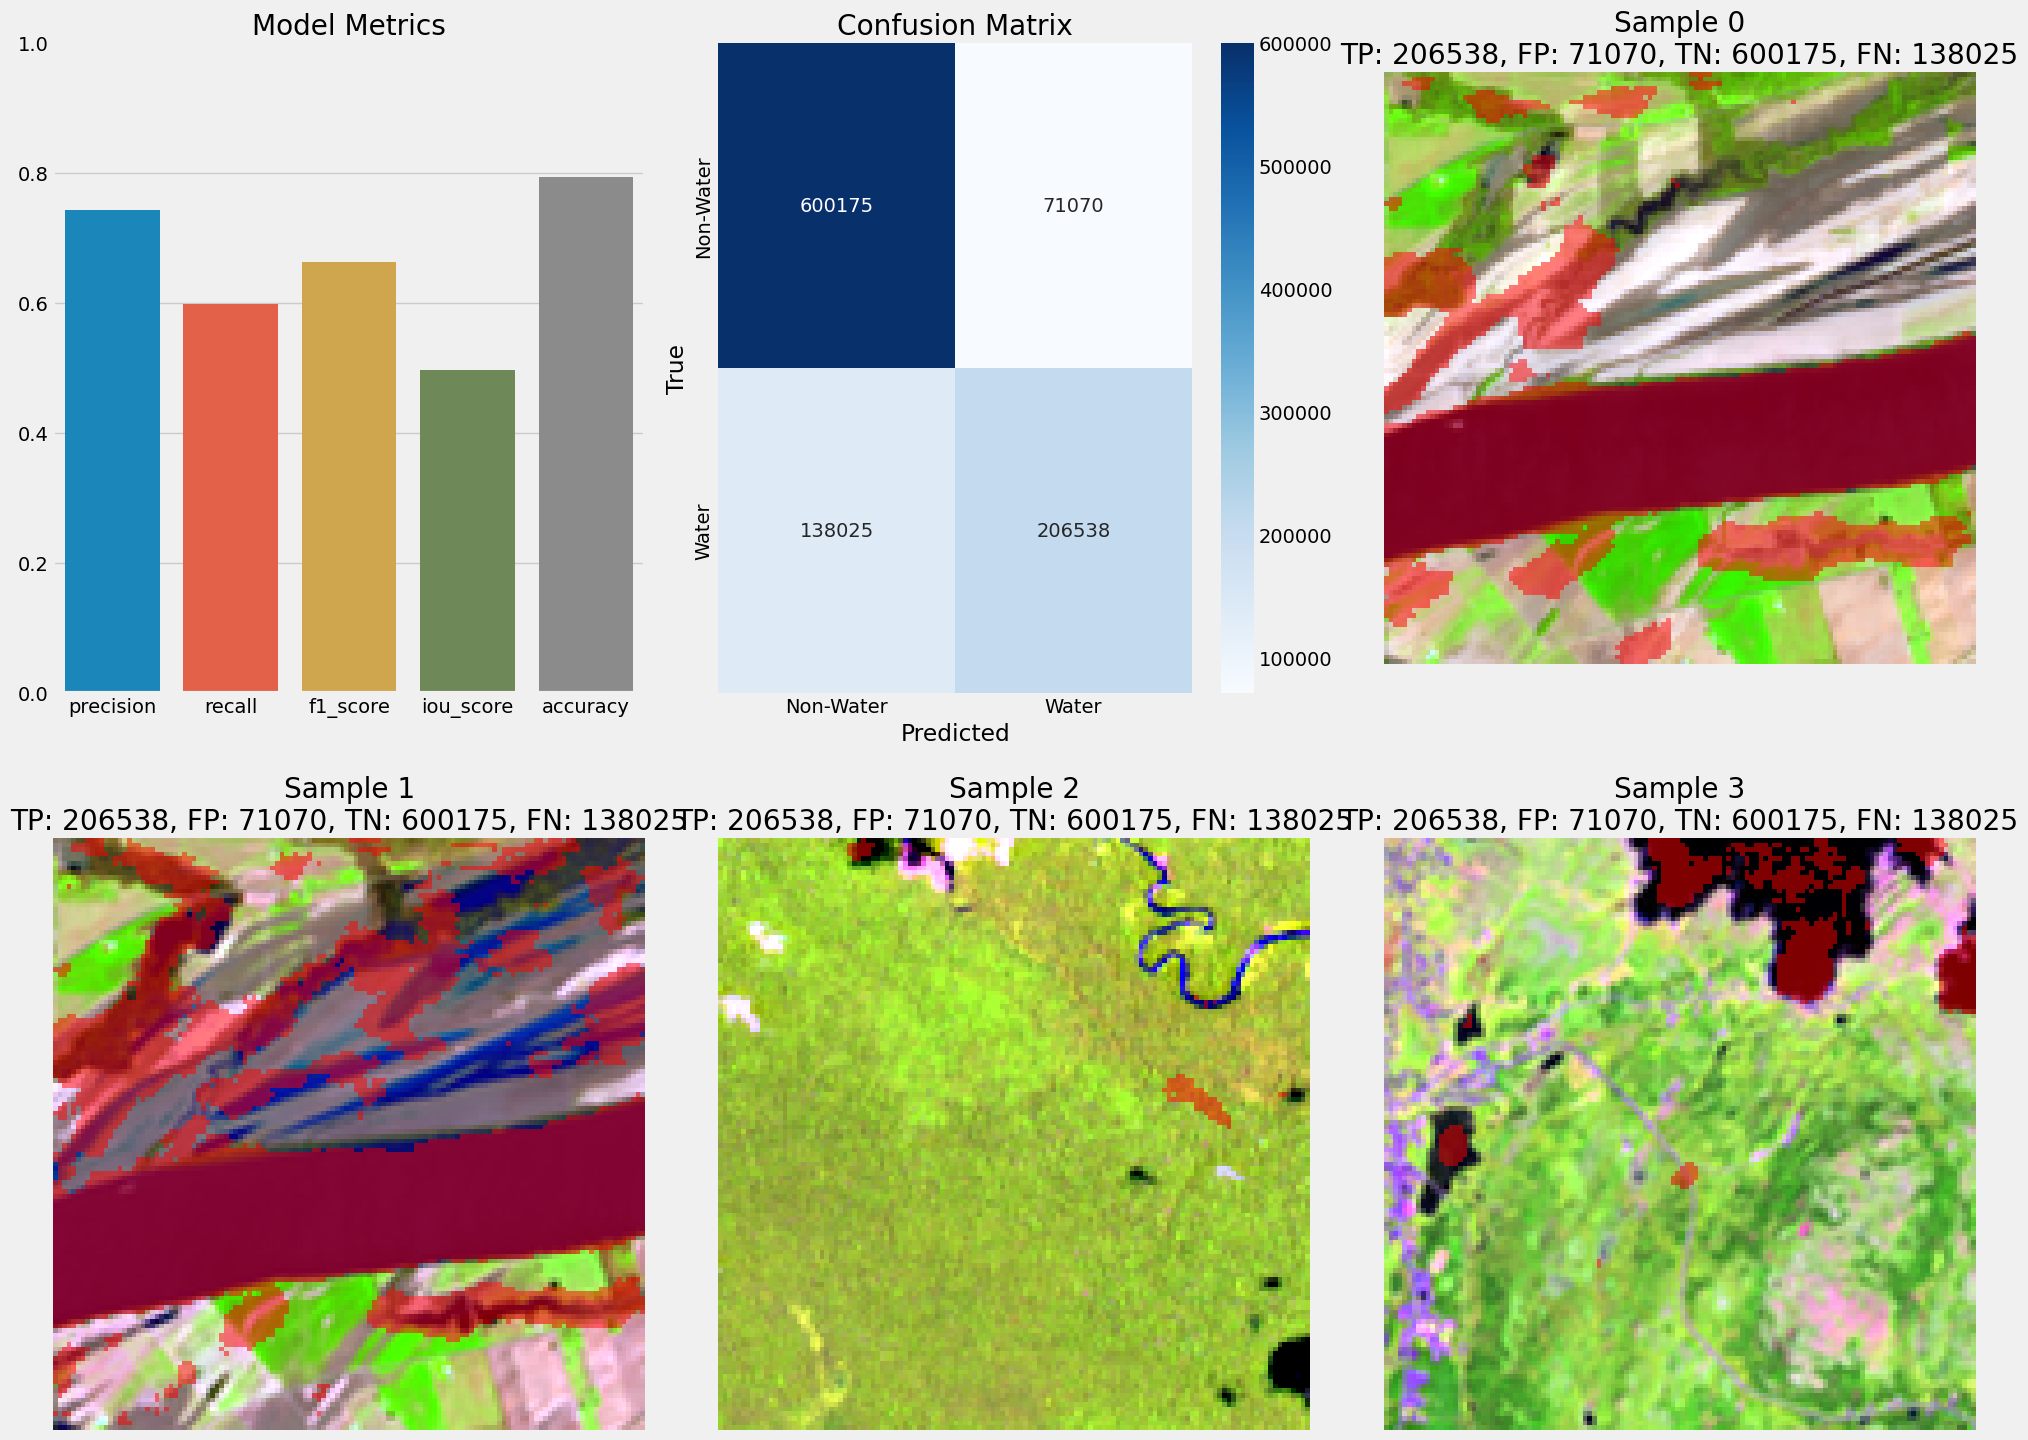

{'precision': 0.7439915276216824,
 'recall': 0.599420135069639,
 'f1_score': 0.6639267982596425,
 'iou_score': 0.49692396898225116,
 'accuracy': 0.794158935546875}

In [18]:
from sklearn.metrics import (precision_score, recall_score, 
                            f1_score, jaccard_score, confusion_matrix)
import seaborn as sns
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Comprehensive evaluation of the water segmentation model
    with robust dimension handling
    """
    # Ensure proper dimensions
    if y_test.ndim == 3:
        y_test = np.expand_dims(y_test, -1)  # Add channel dimension if missing
    elif y_test.ndim == 4 and y_test.shape[-1] == 1:
        y_test = y_test[..., 0]  # Remove extra channel if present
        y_test = np.expand_dims(y_test, -1)  # Then add back correctly

    # Predict probabilities
    y_pred_prob = model.predict(X_test)
    
    # Convert to binary predictions
    y_pred = (y_pred_prob > threshold).astype(np.float32)
    
    # Calculate metrics
    y_test_flat = y_test[..., 0].flatten() 
    y_pred_flat = y_pred[..., 0].flatten()  # Remove channel dim for metrics
    
    metrics = {
        'precision': precision_score(y_test_flat, y_pred_flat),
        'recall': recall_score(y_test_flat, y_pred_flat),
        'f1_score': f1_score(y_test_flat, y_pred_flat),
        'iou_score': jaccard_score(y_test_flat, y_pred_flat),
        'accuracy': np.mean(y_test_flat == y_pred_flat)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test_flat, y_pred_flat)
    
    return metrics, cm, y_pred_prob

def plot_evaluation_results(metrics, cm, sample_idx, X_test, y_test, y_pred_prob):
    """
    Visualize evaluation metrics and sample predictions
    with proper dimension handling
    """
    plt.figure(figsize=(20, 15))
    
    # 1. Plot metrics
    plt.subplot(2, 3, 1)
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    plt.title('Model Metrics')
    plt.ylim(0, 1)
    
    # 2. Plot confusion matrix
    plt.subplot(2, 3, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Water', 'Water'],
                yticklabels=['Non-Water', 'Water'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # 3-6. Plot sample predictions
    for i in range(4):
        idx = sample_idx[i] if isinstance(sample_idx, list) else sample_idx + i
        
        # Create subplot
        plt.subplot(2, 3, 3+i)
        
        # Display false color composite (SWIR1, NIR, Red)
        img = np.stack([X_test[idx,:,:,5],  # SWIR1
                        X_test[idx,:,:,4],  # NIR
                        X_test[idx,:,:,3]], axis=-1)  # Red
        img = exposure.rescale_intensity(img)
        
        # Handle different label dimensions
        if y_test.ndim == 4:
            true_mask = y_test[idx,:,:,0]
        else:
            true_mask = y_test[idx]
            
        # Handle different prediction dimensions
        if y_pred_prob.ndim == 4:
            pred_mask = y_pred_prob[idx,:,:,0] > 0.5
        else:
            pred_mask = y_pred_prob[idx] > 0.5
        
        # Display
        plt.imshow(img)
        plt.imshow(np.ma.masked_where(pred_mask == 0, pred_mask), 
                   cmap='autumn', alpha=0.5)
        plt.title(f'Sample {idx}\nTP: {cm[1,1]}, FP: {cm[0,1]}, TN: {cm[0,0]}, FN: {cm[1,0]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return metrics

# Ensure  validation data has correct shapes
if y_val.ndim == 3:
    y_val = np.expand_dims(y_val, -1)  # Add channel dimension if needed

# Then evaluate
metrics, cm, y_pred_prob = evaluate_model(model, X_val, y_val)
plot_evaluation_results(metrics, cm, 0, X_val, y_val, y_pred_prob)

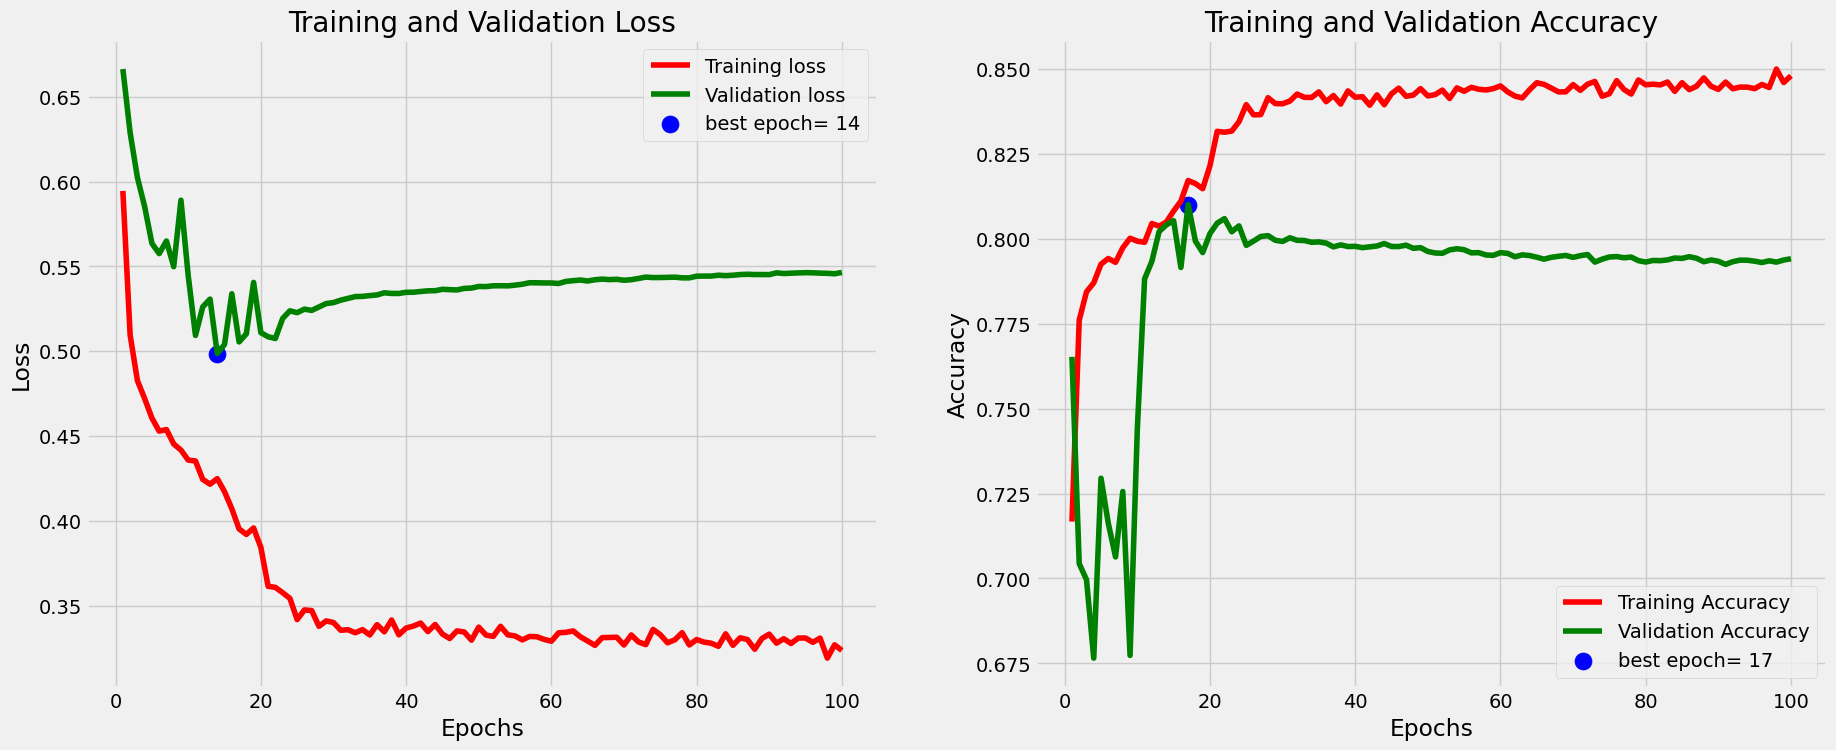

In [19]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()
plot_training(history)

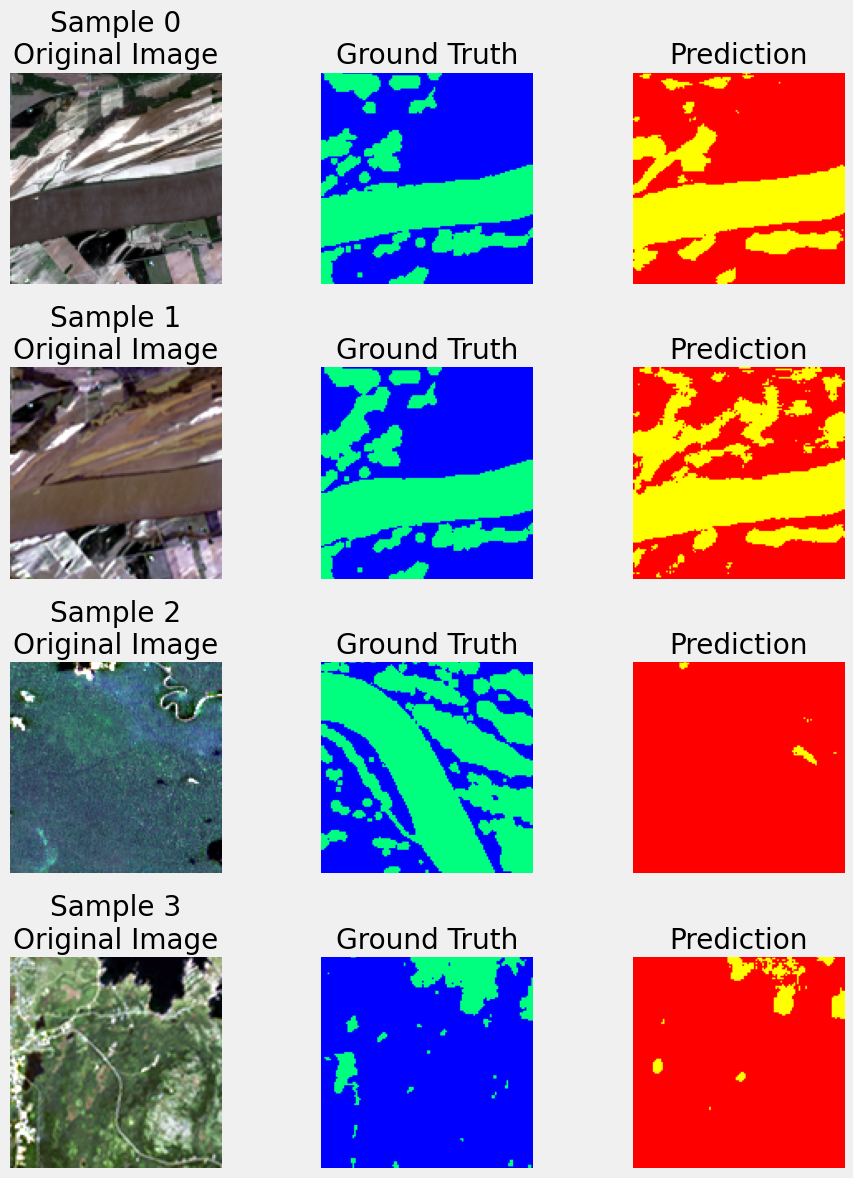

In [25]:
def plot_evaluation_results(sample_idx, X_test, y_test, y_pred_prob):
    """
    Visualize original image, ground truth, and prediction masks
    in a vertical arrangement for each sample
    """
    # Create consistent colormaps
    pred_cmap = plt.cm.autumn
    truth_cmap = plt.cm.winter
    
    n_samples = 4 if isinstance(sample_idx, list) else min(4, len(X_test))
    
    # Create figure with appropriate size
    plt.figure(figsize=(10, 3*n_samples))
    
    for i in range(n_samples):
        idx = sample_idx[i] if isinstance(sample_idx, list) else sample_idx + i
        
        # --- Original Image ---
        plt.subplot(n_samples, 3, i*3 + 1)
        img = np.stack([X_test[idx,:,:,3],  # Red
                       X_test[idx,:,:,2],  # Green
                       X_test[idx,:,:,1]], axis=-1)  # Blue (natural color)
        img = exposure.rescale_intensity(img)
        plt.imshow(img)
        plt.title(f'Sample {idx}\nOriginal Image')
        plt.axis('off')
        
        # --- Ground Truth ---
        plt.subplot(n_samples, 3, i*3 + 2)
        if y_test.ndim == 4:
            truth_mask = y_test[idx,:,:,0]
        else:
            truth_mask = y_test[idx]
        plt.imshow(truth_mask, cmap=truth_cmap)
        plt.title('Ground Truth')
        plt.axis('off')
        
        # --- Prediction ---
        plt.subplot(n_samples, 3, i*3 + 3)
        if y_pred_prob.ndim == 4:
            pred_mask = y_pred_prob[idx,:,:,0]
        else:
            pred_mask = y_pred_prob[idx]
        plt.imshow(pred_mask > 0.5, cmap=pred_cmap)
        plt.title('Prediction')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_evaluation_results([0, 1, 2, 3], X_val, y_val, y_pred_prob)